# Combining spectra before extraction 

Spectra of faint objects can often appear as very faint traces in 2D spectra, making their extraction difficult.  The goal of this notebook is to enable 2D spectra to be co-added in image format, to boost the signal-to-noise of the faint traces and enable their extraction. 

In [104]:
from os import path 
import numpy as np
import copy
import scipy
import datetime
from astropy.io import fits
from astropy.visualization import simple_norm
from astropy import modeling
from matplotlib import pyplot as plt

## Configuration and input data

In [159]:
# Data location 
DATA_DIR = '/Users/rstreet/OMEGAII/data_reduction/SOAR/lco_data-20250902-28'

For the purposes of this example, we have two SOAR spectra, for which the images have had cosmic-rays removed, together with the flat field and bias signatures, and slit-trim and trim corrected.  This is indicated by the 'cfzst' prefix assigned by the Goodman spectroscopic pipeline. 

In [160]:
image_files = [
    'cfzst_0316_OGLE-2024-BLG-0034_SOAR_2_23-04-2025.fits',
    'cfzst_0317_OGLE-2024-BLG-0034_SOAR_2_23-04-2025.fits'
]
image_paths = [path.join(DATA_DIR, f) for f in image_files]

output_image_name = 'cfzst_03160317_OGLE-2024-BLG-0034_SOAR_2_23-04-2025.fits'

In [171]:
def load_2d_spectra(image_paths, debug=False):
    images = {}
    for fpath in image_paths:
        with fits.open(fpath) as hdul:
            if debug: print(hdul)
                
            entry = {
                'header': hdul[0].header,
                'data': hdul[0].data
            }
            if len(hdul) > 1: 
                entry['mask_header'] = hdul[1].header
                entry['mask_data'] = hdul[1].data
                entry['uncert_header'] = hdul[2].header
                entry['uncert_data'] = hdul[2].data
            
            images[path.basename(fpath)] = entry
            
        hdul.close()

    return images

In [172]:
images = load_2d_spectra(image_paths)

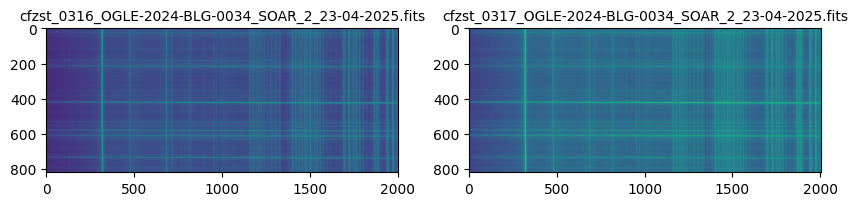

In [5]:
fig, axs = plt.subplots(1,2, figsize=(10,10))

for i,image_name in enumerate(image_files):
    norm = simple_norm(images[image_name]['data'], 'log')
    axs[i].imshow(images[image_name]['data'], norm=norm)
    axs[i].set_title(image_name, fontsize=10)

## Aligning the spectra in 2D

In principle, for spectra taken close together in time, we should be able to assume that the observational conditions were very similar.  I.e., the atmospheric transparency should be the same (so the intensity of the different stellar spectra should be consistent), and the gravity vector on the instrument should be as similar as possible.  This can influence where the lines appear in the horizonal (wavelength) direction.  

So we need to determine the x, y offsets between the images, which should be small, and for the time being we neglect any instrumental flexing. 

We can use 2D cross-correlation for this but the drawback here is that it is extremely slow.

In [6]:
# 2D cross-correlation of both images is very slow
#image_data = [images[f]['data'] for f in image_files]

#corr = scipy.signal.correlate2d(image_data[0], image_data[1]) 

#print(corr)

Instead we can take advantage of the fact that images are known to have strong linear features in both x and y directions that are consistent between both frames.  

In [9]:
image_data = [images[f]['data'] for f in image_files]

# Sum the pixel values of both images in both x and y directions 
x1 = image_data[0].sum(axis=0)
y1 = image_data[0].sum(axis=1)

x2 = image_data[0].sum(axis=0)
y2 = image_data[0].sum(axis=1)

(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

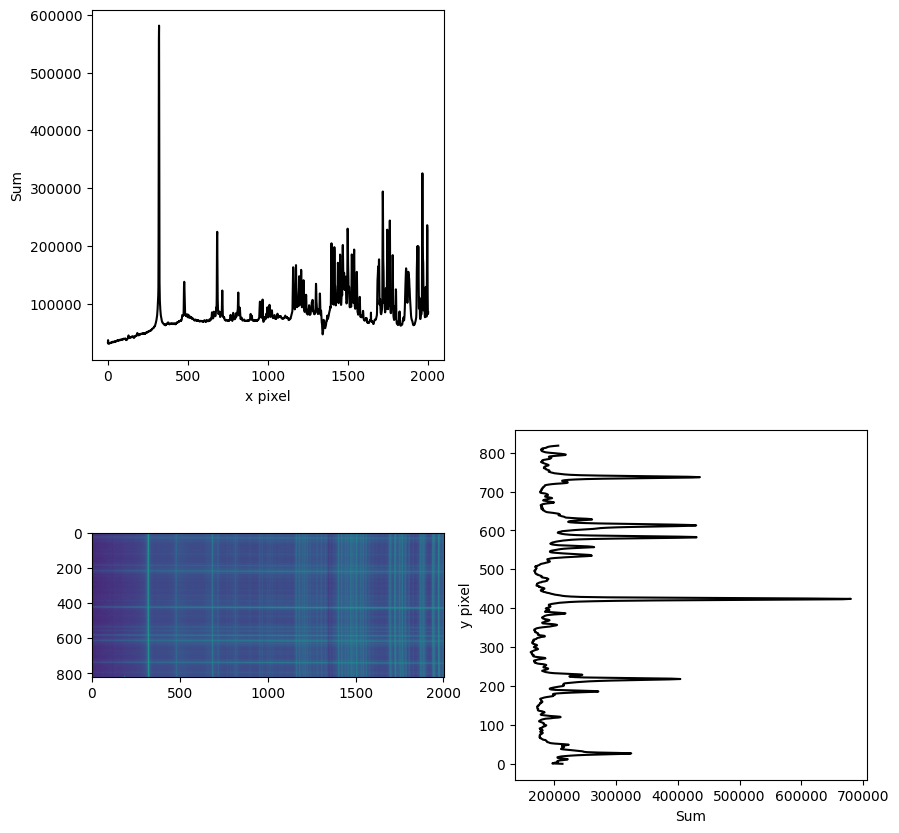

In [22]:
# Illustrate this approach

fig, axs = plt.subplots(2,2, figsize=(10,10))

norm = simple_norm(image_data[0], 'log')

# Plot the image
axs[1,0].imshow(image_data[0], norm=norm)

# Plot the horizonal sum to the right
axs[1,1].plot(y1, np.arange(0, len(y1), 1), c='black', ls='-')
axs[1,1].set_xlabel('Sum')
axs[1,1].set_ylabel('y pixel')

# Plot the vertical sum to the top
axs[0,0].plot(np.arange(0, len(x1), 1), x1, c='black', ls='-')
axs[0,0].set_ylabel('Sum')
axs[0,0].set_xlabel('x pixel')

# Switch off the plot 
axs[0,1].axis('off')

Now we can compare the x, y sums from both images.

Text(0, 0.5, 'y pixel')

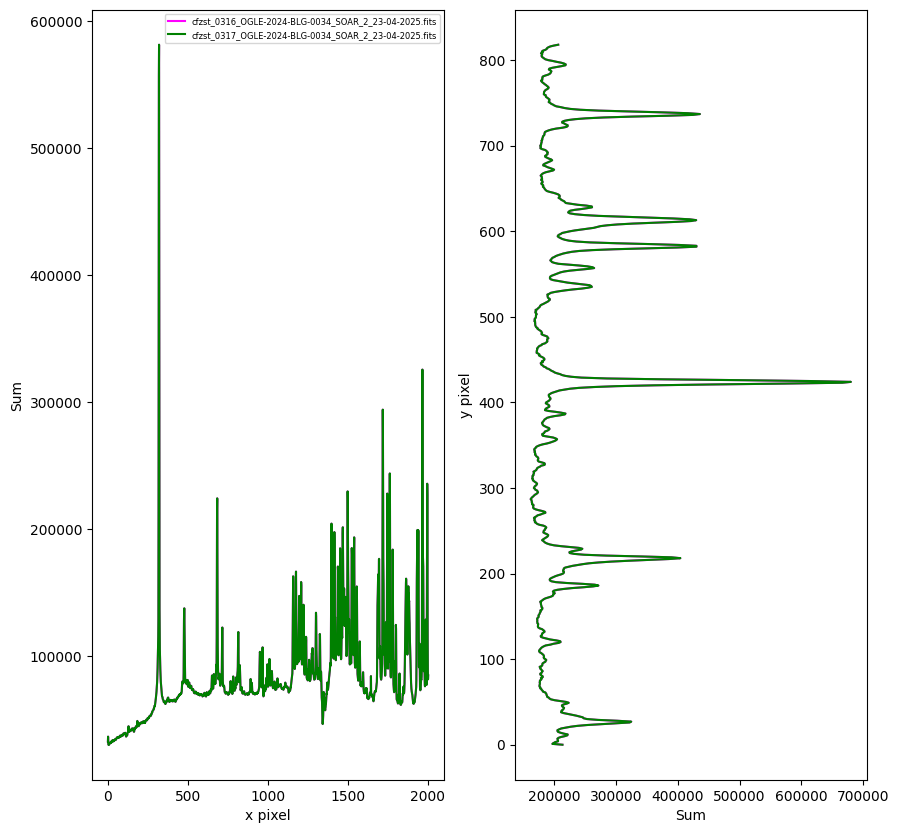

In [26]:
fig, axs = plt.subplots(1,2, figsize=(10,10))

axs[0].plot(np.arange(0, len(x1), 1), x1, c='magenta', ls='-', label=image_files[0])
axs[0].plot(np.arange(0, len(x2), 1), x2, c='green', ls='-', label=image_files[1])
axs[0].set_ylabel('Sum')
axs[0].set_xlabel('x pixel')
axs[0].legend(fontsize=6)

axs[1].plot(y1, np.arange(0, len(y1), 1), c='magenta', ls='-')
axs[1].plot(y1, np.arange(0, len(y2), 1), c='green', ls='-')
axs[1].set_xlabel('Sum')
axs[1].set_ylabel('y pixel')

We can now use 1D correlation for each axis which should be faster.

In [65]:
corr_x = scipy.ndimage.correlate(x1, x2, mode='constant')

idx = np.argmax(corr_x)

The drawback with this method is that it can only correlate at the intervals of measurement provided by the input arrays, in this case by whole pixels.  So we cannot get sub-pixel alignment without interpolation.  

In [82]:
sx1 = scipy.interpolate.make_interp_spline(np.arange(0, len(x1), 1), x1)
sx2 = scipy.interpolate.make_interp_spline(np.arange(0, len(x2), 1), x2)

pix_res = 0.1
x1highres = sx1(np.arange(0, len(x1), pix_res))
x2highres = sx2(np.arange(0, len(x2), pix_res))

scorr_x = scipy.ndimage.correlate(x1highres, x2highres, mode='constant')

sidx = np.argmax(scorr_x)
print('Correlation peak: ', sidx, scorr_x[sidx])

# Calculate the pixel corresponding to the interpolated peak pixel
peak_pixel_x = sidx * pix_res
print('Peak correlation at x pixel ' + str(peak_pixel))

Correlation peak:  10025 172135866650378.2
Peak correlation at x pixel 1002.5


In [83]:
sy1 = scipy.interpolate.make_interp_spline(np.arange(0, len(y1), 1), y1)
sy2 = scipy.interpolate.make_interp_spline(np.arange(0, len(y2), 1), y2)

pix_res = 0.1
y1highres = sy1(np.arange(0, len(y1), pix_res))
y2highres = sy2(np.arange(0, len(y2), pix_res))

scorr_y = scipy.ndimage.correlate(y1highres, y2highres, mode='constant')

sidy = np.argmax(scorr_y)
print('Correlation peak: ', sidy, scorr_y[sidy])

# Calculate the pixel corresponding to the interpolated peak pixel
peak_pixel_y = sidy * pix_res
print('Peak correlation at y pixel ' + str(peak_pixel))

Correlation peak:  4095 371697669432611.44
Peak correlation at y pixel 1002.5


Text(0.5, 1.0, 'Peak correlation at pixel 409.5')

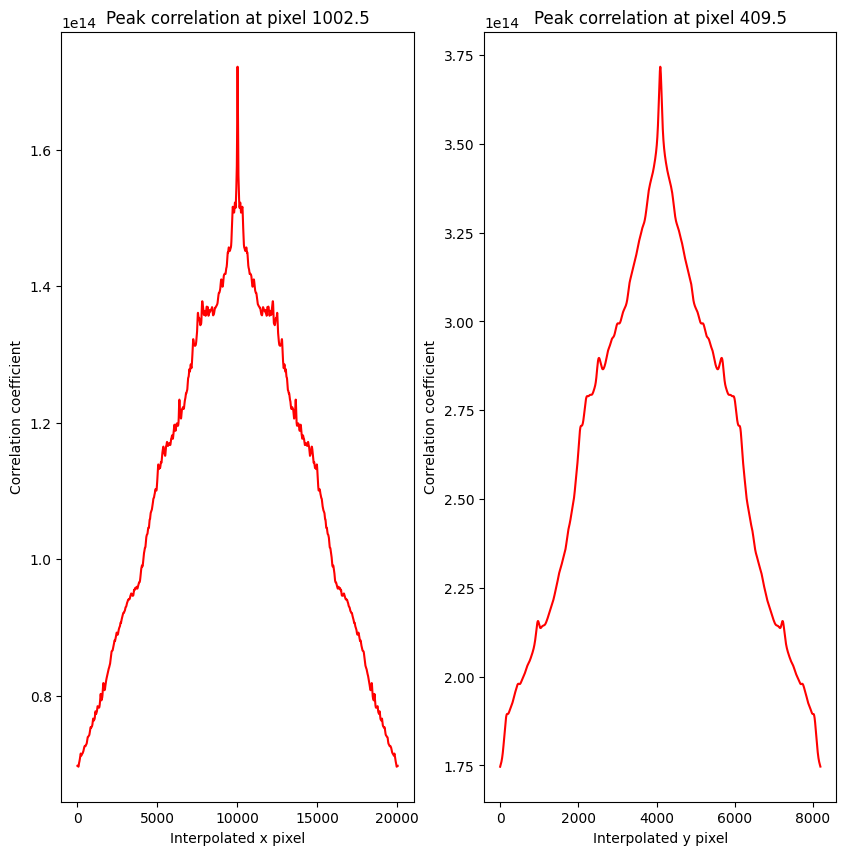

In [84]:
fig, axs = plt.subplots(1,2, figsize=(10,10))

axs[0].plot(np.arange(0, len(scorr_x), 1), scorr_x, 'r-')
axs[0].set_xlabel('Interpolated x pixel')
axs[0].set_ylabel('Correlation coefficient')
axs[0].set_title('Peak correlation at pixel ' + str(peak_pixel_x))

axs[1].plot(np.arange(0, len(scorr_y), 1), scorr_y, 'r-')
axs[1].set_xlabel('Interpolated y pixel')
axs[1].set_ylabel('Correlation coefficient')
axs[1].set_title('Peak correlation at pixel ' + str(peak_pixel_y))

To determine the offset between the images, we compare these correlation peaks with the pixel center of the first image in the list, which was used as the reference.

In [91]:
print(image_data[0].shape)
xcen = image_data[0].shape[1] / 2.0
ycen = image_data[0].shape[0] / 2.0
print('Spectrum 1 pixel center = ' + str(xcen) + ', ' + str(ycen))

(819, 2005)
Spectrum 1 pixel center = 1002.5, 409.5


This proves that the peak of correlation in both x and y is the image center.  This means we can safely co-add the images without needing to consider any resampling.  

## Co-adding the 2D spectra

Here we go add the data and output the results as a FITS file with an updated header. 

In [96]:
# Coadd the image arrays 
coadd_data = np.array(image_data).sum(axis=0)
print(coadd_data.shape)

(819, 2005)


Text(0.5, 1.0, 'Coadded 2D spectrum')

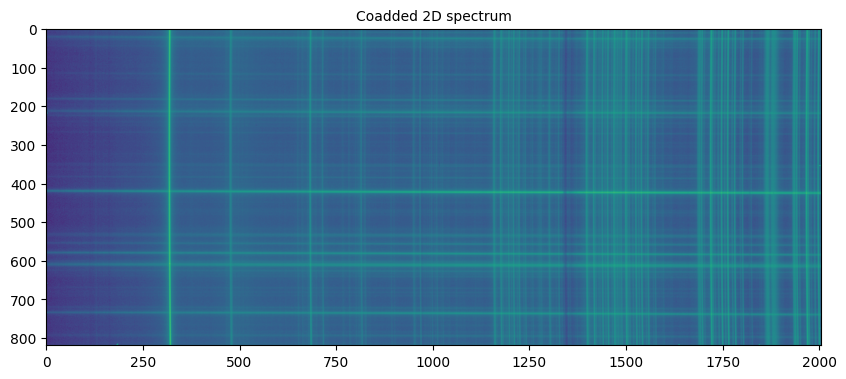

In [97]:
fig, axs = plt.subplots(1,1, figsize=(10,10))

norm = simple_norm(coadd_data, 'log')
axs.imshow(coadd_data, norm=norm)
axs.set_title('Coadded 2D spectrum', fontsize=10)

In [102]:
# Build the header from the contents of the first image header, but update the parameters that have changed as a result of coadding
hdr1 = images[image_files[0]]['header'] 
hdr2 = images[image_files[1]]['header']

hdr = copy.deepcopy(hdr1)
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2005                                                  
NAXIS2  =                  819                                                  
EXTEND  =                    T                                                  
DATE-OBS= '2025-04-23T04:38:19.770' / DATE-OBS Format: YYYY-MM-DDThh:mm:ss.sss  
DATE    = '2025-04-23'         / Date Format is YYYY-MM-DD                      
TIME    = '04:38:19.770 to 05:01:39.765' / ~ Start & Stop of Exposure           
N_PRM0  =                   59 / Status                                         
PG0_0   =                24624 / Camera Flags,                                  
PG0_1   =          2147483.647 / Camera Up Time, HH:MM:SS.sss                   
PG0_2   =                   

In [101]:
# Check the NAXIS values remained the same 
assert(hdr['NAXIS1'] == coadd_data.shape[1])
assert(hdr['NAXIS2'] == coadd_data.shape[0])

In [122]:
# Update the timestamps.  
# Due to the formatting of the SOAR headers, the DATE-OBS stamp represents the start of the first exposure
t1 = datetime.datetime.strptime(hdr1['DATE-OBS'], '%Y-%m-%dT%H:%M:%S.%f')
t2 = datetime.datetime.strptime(hdr2['DATE-OBS'], '%Y-%m-%dT%H:%M:%S.%f')

start = min(t1, t2)
hdr['DATE-OBS'] = start.strftime('%Y-%m-%dT%H:%M:%S.%f')

# The TIME keyword is a string in the format: "%H:%M:%S.%f to %H:%M:%S.%f" representing the start and end time of the exposures. 
# This is approximate.  Here we take the start from the first exposure and the end from the second, assuming they were back-to-back
t1 = datetime.datetime.strptime(str(hdr1['TIME']).split()[0], '%H:%M:%S.%f')
t2 = datetime.datetime.strptime(str(hdr2['TIME']).split()[0], '%H:%M:%S.%f')
start = min(t1, t2)

t1 = datetime.datetime.strptime(str(hdr1['TIME']).split()[-1], '%H:%M:%S.%f')
t2 = datetime.datetime.strptime(str(hdr2['TIME']).split()[-1], '%H:%M:%S.%f')
end = max(t1, t2)

hdr['TIME'] = start.strftime('%H:%M:%S.%f') + ' to ' + end.strftime('%H:%M:%S.%f')

# Similarly, update the UT timestamp 
t1 = datetime.datetime.strptime(str(hdr1['UT']).split()[0], '%H:%M:%S.%f')
t2 = datetime.datetime.strptime(str(hdr2['UT']).split()[0], '%H:%M:%S.%f')
ut = min(t1, t2) 
hdr['UT'] = ut.strftime('%H:%M:%S.%f')

In [148]:
# Update filename stored in header 
hdr['GSP_FNAM'] = output_image_name

In [149]:
# Update the exposure time 
hdr['EXPTIME'] = hdr1['EXPTIME'] + hdr2['EXPTIME']

# Correct the readnoise for multiple exposures
hdr['RDNOISE'] = hdr1['RDNOISE'] + hdr2['RDNOISE']

In [150]:
# A fully formed SOAR FITS file needs the mask and uncertainties HDUs as well as the coadded images
mask_hdr = images[image_files[0]]['mask_header']
mask_data = images[image_files[0]]['mask_data']

uncert_hdr = images[image_files[0]]['uncert_header']
uncert_data = np.sqrt(images[image_files[0]]['uncert_data']**2 + images[image_files[1]]['uncert_data']**2)

In [152]:
# Output updated FITS file 
hdu0 = fits.PrimaryHDU(data=coadd_data, header=hdr)
hdu1 = fits.ImageHDU(data=mask_data, header=mask_hdr)
hdu2 = fits.ImageHDU(data=uncert_data, header=uncert_hdr)
new_hdul = fits.HDUList([hdu0, hdu1, hdu2])
new_hdul.writeto(path.join(DATA_DIR, output_image_name), overwrite=True)

## Combining three 2D spectra

In [173]:
# Data location 
DATA_DIR = '/Users/rstreet/OMEGAII/data_reduction/SOAR/lco_data-20250902-36'

image_files = [
    'cfzst_0287_OGLE-2024-BLG-0034_SOAR_spec_2_28-09-2024.fits',
    'cfzst_0288_OGLE-2024-BLG-0034_SOAR_spec_2_28-09-2024.fits',
    'cfzst_0289_OGLE-2024-BLG-0034_SOAR_spec_2_28-09-2024.fits'
]
image_paths = [path.join(DATA_DIR, f) for f in image_files]

output_image_name = 'cfzst_0287x3_OGLE-2024-BLG-0034_SOAR_spec_2_28-09-2024.fits'

In [178]:
images = load_2d_spectra(image_paths, debug=True)
for image in image_files:
    print(images[image].keys())

dict_keys(['header', 'data'])
dict_keys(['header', 'data'])
dict_keys(['header', 'data'])


Interestingly, these exposures don't appear to have masks or uncertainty HDUs in their FITS files, although they purport to have been reduced following the same process as the earlier data.  

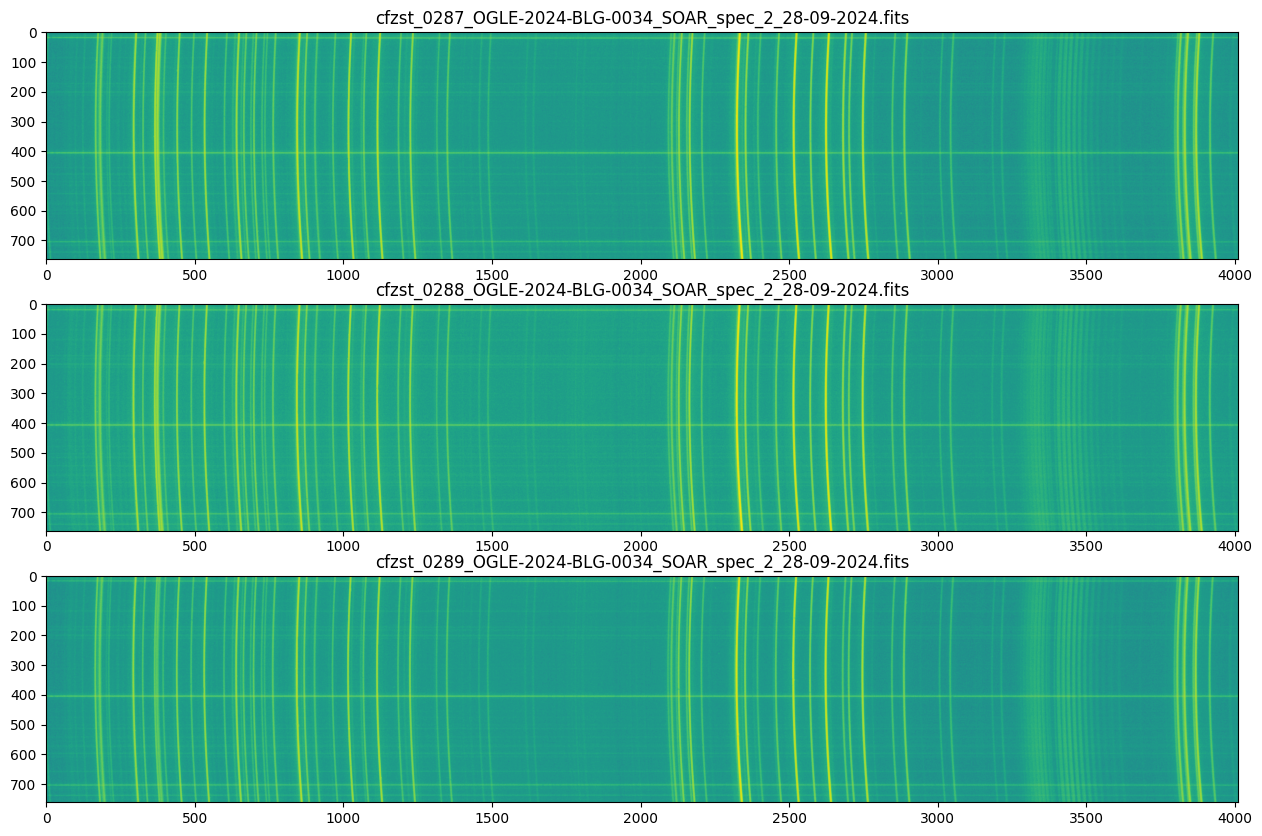

In [182]:
fig, axs = plt.subplots(3,1, figsize=(20,10))

for i,image_name in enumerate(image_files):
    norm = simple_norm(images[image_name]['data'], 'log')
    axs[i].imshow(images[image_name]['data'], norm=norm)
    axs[i].set_title(image_name, fontsize=12)

Following the analysis above, we assume that we can coadd these data by simple stacking. 

In [183]:
# Coadd all three images 
image_data = [images[f]['data'] for f in image_files]
coadd_data = np.array(image_data).sum(axis=0)

Text(0.5, 1.0, 'Coadded 2D spectrum')

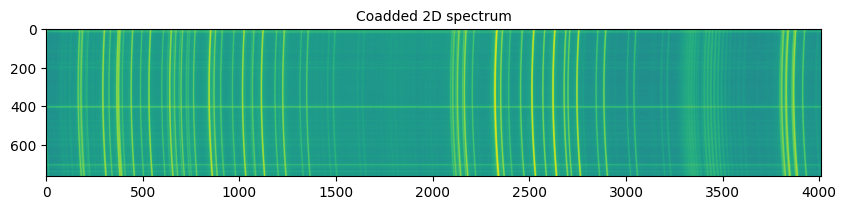

In [184]:
fig, axs = plt.subplots(1,1, figsize=(10,10))

norm = simple_norm(coadd_data, 'log')
axs.imshow(coadd_data, norm=norm)
axs.set_title('Coadded 2D spectrum', fontsize=10)

In [185]:
# Build the FITS output as before 
hdr1 = images[image_files[0]]['header'] 
hdr2 = images[image_files[1]]['header']
hdr3 = images[image_files[1]]['header']

hdr = copy.deepcopy(hdr1)

In [186]:
# Update the timestamps.  
# Due to the formatting of the SOAR headers, the DATE-OBS stamp represents the start of the first exposure
t1 = datetime.datetime.strptime(hdr1['DATE-OBS'], '%Y-%m-%dT%H:%M:%S.%f')
t2 = datetime.datetime.strptime(hdr2['DATE-OBS'], '%Y-%m-%dT%H:%M:%S.%f')
t3 = datetime.datetime.strptime(hdr3['DATE-OBS'], '%Y-%m-%dT%H:%M:%S.%f')

start = min(t1, t2)
start = min(start, t3)
hdr['DATE-OBS'] = start.strftime('%Y-%m-%dT%H:%M:%S.%f')

# The TIME keyword is a string in the format: "%H:%M:%S.%f to %H:%M:%S.%f" representing the start and end time of the exposures. 
# This is approximate.  Here we take the start from the first exposure and the end from the second, assuming they were back-to-back
t1 = datetime.datetime.strptime(str(hdr1['TIME']).split()[0], '%H:%M:%S.%f')
t2 = datetime.datetime.strptime(str(hdr2['TIME']).split()[0], '%H:%M:%S.%f')
t3 = datetime.datetime.strptime(str(hdr3['TIME']).split()[0], '%H:%M:%S.%f')
start = min(t1, t2)
start = min(start, t3)

t1 = datetime.datetime.strptime(str(hdr1['TIME']).split()[-1], '%H:%M:%S.%f')
t2 = datetime.datetime.strptime(str(hdr2['TIME']).split()[-1], '%H:%M:%S.%f')
t3 = datetime.datetime.strptime(str(hdr3['TIME']).split()[-1], '%H:%M:%S.%f')
end = max(t1, t2)
end = max(start, t3)

hdr['TIME'] = start.strftime('%H:%M:%S.%f') + ' to ' + end.strftime('%H:%M:%S.%f')

# Similarly, update the UT timestamp 
t1 = datetime.datetime.strptime(str(hdr1['UT']).split()[0], '%H:%M:%S.%f')
t2 = datetime.datetime.strptime(str(hdr2['UT']).split()[0], '%H:%M:%S.%f')
t3 = datetime.datetime.strptime(str(hdr2['UT']).split()[0], '%H:%M:%S.%f')
ut = min(t1, t2) 
ut = min(start, t3) 
hdr['UT'] = ut.strftime('%H:%M:%S.%f')

# Update filename stored in header 
hdr['GSP_FNAM'] = output_image_name

# Update the exposure time 
hdr['EXPTIME'] = hdr1['EXPTIME'] + hdr2['EXPTIME'] + hdr3['EXPTIME']

# Correct the readnoise for multiple exposures
hdr['RDNOISE'] = hdr1['RDNOISE'] + hdr2['RDNOISE'] + hdr3['RDNOISE']

In [187]:
# Output updated FITS file 
hdu0 = fits.PrimaryHDU(data=coadd_data, header=hdr)
new_hdul = fits.HDUList([hdu0])
new_hdul.writeto(path.join(DATA_DIR, output_image_name), overwrite=True)